<a href="https://colab.research.google.com/github/HiraiG/zerotsuku_5_academix/blob/main/10%E5%9B%9E/10_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 拡散モデル勉強会

## ライブラリのインポート

In [11]:
import math
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

from tqdm.notebook import tqdm

## ハイパーパラメータの設定

In [2]:
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 図の可視化をする関数

In [3]:
def show_images(images,
                labels=None,
                rows=2,
                cols=10
):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax = fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            if labels is not None:
                ax.set_xlabel(labels[i].item())
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            i += 1
    plt.tight_layout()
    plt.show()

## 位置エンコード

In [5]:
def _pos_encoding(time_idx,
                  output_dim,
                  device='cpu'
):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encoding(timesteps,
                 output_dim,
                 device='cpu'
):
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

## 畳み込みニューラルネットワーク

In [6]:
class ConvBlock(nn.Module):
    def __init__(self,
                 in_ch,
                 out_ch,
                 time_embed_dim
    ):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

## U-Net

In [7]:
class UNetCond(nn.Module):
    def __init__(self,
                 in_ch=1,
                 time_embed_dim=100,
                 num_labels=None
    ):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

        if num_labels is not None:
            self.label_emb = nn.Embedding(num_labels, time_embed_dim)

    def forward(self,
                x,
                timesteps,
                labels=None
    ):
        t = pos_encoding(timesteps, self.time_embed_dim)

        if labels is not None:
            t += self.label_emb(labels)

        x1 = self.down1(x, t)
        x = self.maxpool(x1)
        x2 = self.down2(x, t)
        x = self.maxpool(x2)

        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)
        return x

## ノイズの付与

In [8]:
class Diffuser:
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 device='cpu'
    ):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        alpha_bar = alpha_bar.view(alpha_bar.size(0), 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self,
                model,
                x,
                t,
                labels,
                gamma
    ):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t, labels)
            eps_uncond = model(x, t)
            eps = eps_uncond + gamma * (eps - eps_uncond)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None, gamma=3.0):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)
        if labels is None:
            labels = torch.randint(0, 10, (len(x),), device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels, gamma)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images, labels

## データとモデルの定義

In [9]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4425190.26it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 126944.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1193880.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5325839.75it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 学習イテレータ

In [12]:
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    # generate samples every epoch ===================
    #images, labels = diffuser.sample(model)
    #show_images(images, labels)
    # ================================================

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

        if np.random.random() < 0.1:
            labels = None

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0 | Loss: 0.033709584808807126


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.025644138973674922


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.022940445022145185


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.021103753215833895


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.01936564051599772


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.01900705280723666


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.018029418305309214


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.01803823012803028


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.02049955790802868


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.018870781346567785


## 可視化

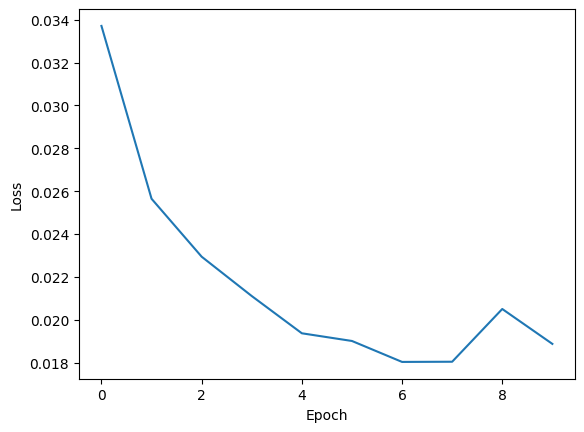

  0%|          | 0/1000 [00:00<?, ?it/s]

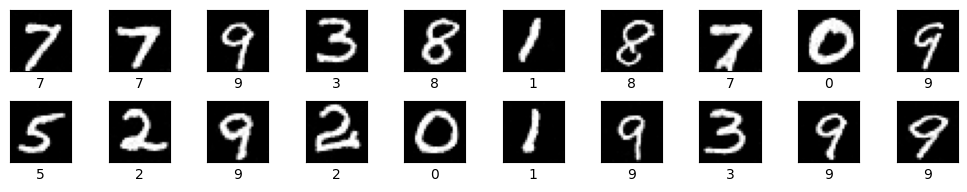

In [13]:
# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# generate samples
images, labels = diffuser.sample(model)
show_images(images, labels)